In [1]:
import os
from torchvision import transforms
from data_utils import Normalization, ToTensor
from data_utils import Dataset, DataLoader

data_dir = '/mnt/hdd1/c-MET_datasets/Lung_c-MET IHC_scored/DL-based_tumor_seg_dataset'
batch_size = 18 # number of samples in an WSI (or a source image)

transform = transforms.Compose([Normalization(mean=0.5, std=0.5), ToTensor()])
dataset = Dataset(data_dir=os.path.join(data_dir, 'test'), transform = transform)
loader = DataLoader(dataset, batch_size = batch_size, shuffle=False)

In [5]:
import torch
from model import UNet
import torch.nn as nn

rank = 4
torch.cuda.set_device(rank)

device = torch.device(f'cuda:{rank}')
net = UNet().to(device)

fn_loss = nn.BCEWithLogitsLoss().to(device)

ckpt_dir = '/mnt/hdd1/model/Lung_c-MET IHC_scored/UNet/checkpoint'

def net_test_load(ckpt_dir, net, epoch = 0):
    if not os.path.exists(ckpt_dir): # 저장된 네트워크가 없다면 인풋을 그대로 반환
        epoch = 0
        return net
    
    ckpt_lst = os.listdir(ckpt_dir) # ckpt_dir 아래 있는 모든 파일 리스트를 받아온다
    ckpt_lst.sort(key = lambda f : int(''.join(filter(str.isdigit,f))))

    print(f'{ckpt_lst[epoch-1]}')
    dict_model = torch.load('%s/%s' % (ckpt_dir,ckpt_lst[epoch-1]), map_location=device)
    
    net.load_state_dict(dict_model['net'])

    return net

net = net_test_load(ckpt_dir = ckpt_dir, net = net, epoch = 120) # 저장된 네트워크 불러오기


model_epoch120.pth


In [6]:
import numpy as np

fn_tonumpy = lambda x : x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x, mean, std : (x*std) + mean
fn_classifier = lambda x : 1.0 * (x > 0.5)

results = []

with torch.no_grad(): 
    net.eval() 
    loss_arr = []
    
    
    for batch, data in enumerate(loader, 1):
        # forward
        label = data['label'].to(device)
        input = data['input'].to(device)
        output = net(input)

        # loss 
        loss = fn_loss(output,label)
        loss_arr += [loss.item()]
        
        input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
        label = np.squeeze(fn_tonumpy(label), axis=-1)
        pred = np.squeeze(fn_tonumpy(fn_classifier(output)), axis=-1)
        prob = np.squeeze(fn_tonumpy(output), axis=-1)
        results.append((input, label, pred, prob))
        
    print('test : Loss %.4f'%(np.mean(loss_arr)))

test : Loss 0.2644


In [9]:
from sklearn.metrics import confusion_matrix as c_mat
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score 

def compute_performance(label, output, pred, isprint = False):
    # to 1-dimension
    label = label.flatten()
    output = output.flatten()
    pred = pred.flatten()
    
    con_mat = c_mat(label, pred)

    accuracy = accuracy_score(label, pred)
    recall = recall_score(label, pred)
    precision = precision_score(label, pred)
    f1_score_ = f1_score(label, pred)
    
    try: auc_score = roc_auc_score(label, output)
    except: auc_score = None

    if isprint:
        print(con_mat)
        print(f'accuracy: {accuracy:.3f} | recall: {recall:.3f} | precision: {precision:.3f} | f1 score: {f1_score_:.3f} | AUC score: {auc_score:.3f}')

    return accuracy, recall, precision, f1_score_, auc_score

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[514114  33835]
 [ 53741 577958]]
accuracy: 0.926 | recall: 0.915 | precision: 0.945 | f1 score: 0.930 | AUC score: 0.980


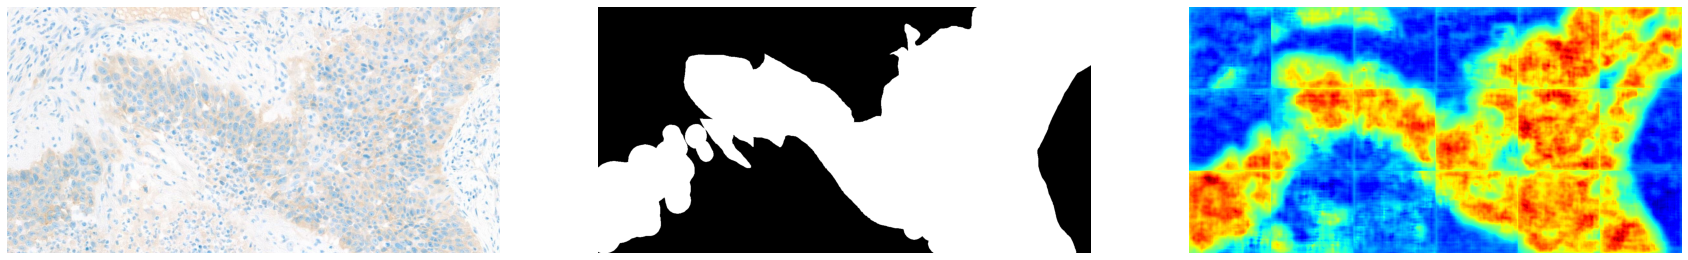

[[273087 107008]
 [ 86313 713240]]
accuracy: 0.836 | recall: 0.892 | precision: 0.870 | f1 score: 0.881 | AUC score: 0.897


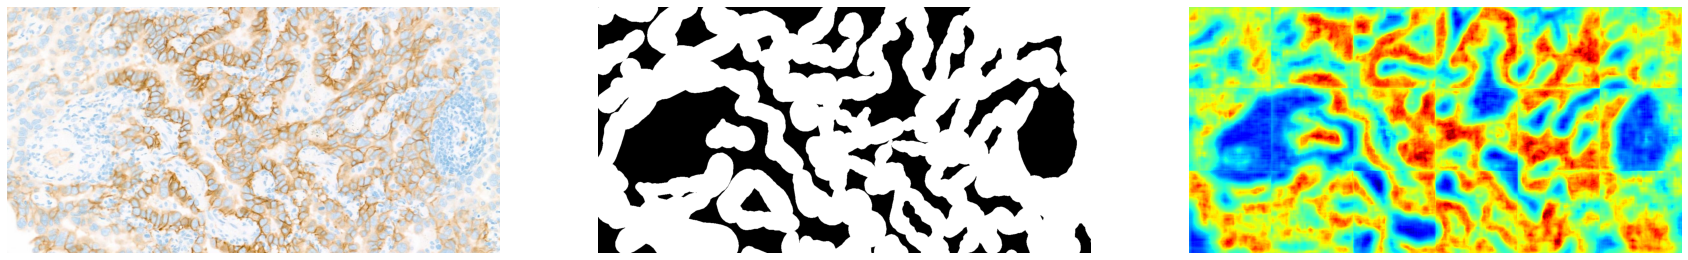

[[214588  53206]
 [ 87752 824102]]
accuracy: 0.881 | recall: 0.904 | precision: 0.939 | f1 score: 0.921 | AUC score: 0.939


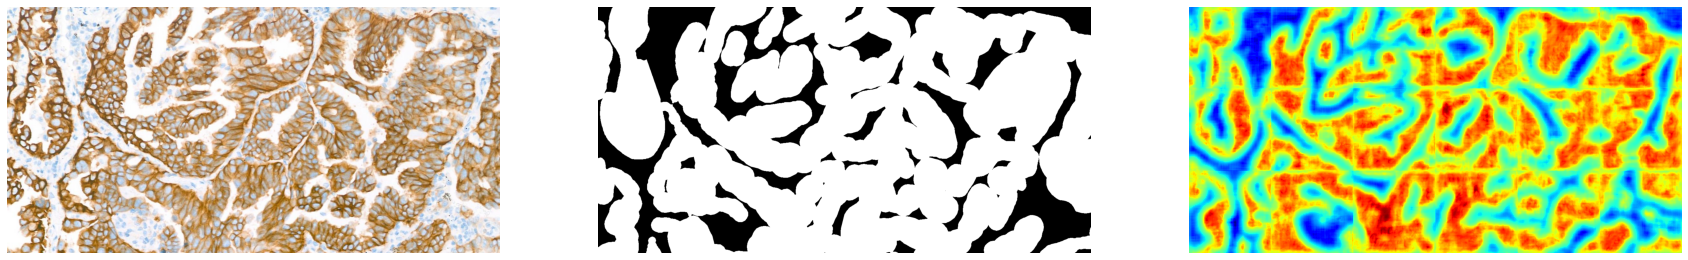

[[471194  45372]
 [ 53446 609636]]
accuracy: 0.916 | recall: 0.919 | precision: 0.931 | f1 score: 0.925 | AUC score: 0.974


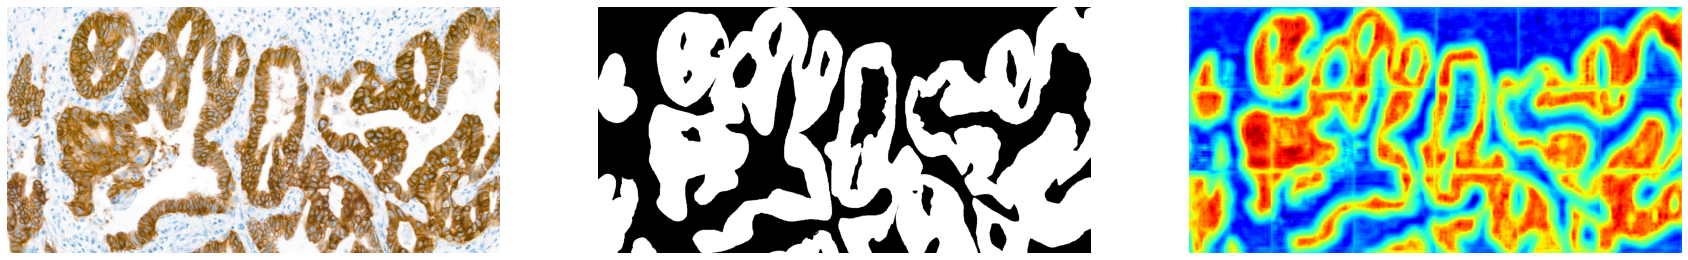

patch-level average | accuracy: 0.887 | recall: 0.891 | precision: 0.903 | f1 score: 0.894 | AUC score: 0.939
wsi-level average | accuracy: 0.890 | recall: 0.908 | precision: 0.921 | f1 score: 0.914 | AUC score: 0.947


In [26]:
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib import cm

def make_heatmap(output):
    output = output-output.min()
    output = output/output.max()
    heatmap = cm.jet(output)
    return heatmap

save_dir = '/mnt/hdd1/model/Lung_c-MET IHC_scored/UNet/output'

try: os.makedirs(save_dir)
except: pass

nrow, ncol = 3, 6

patch_level_performance = []
wsi_level_performance = []
for i, result in enumerate(results):

    # visualization on WSI (or source image)-level
    sample = np.empty((nrow*256, ncol*256, 3))
    label = np.empty((nrow*256, ncol*256))
    predict = np.empty((nrow*256, ncol*256))
    output = np.empty((nrow*256, ncol*256))

    x, y, pred, prob = result
    
    for j, (x_j, y_j, pred_j, prob_j) in enumerate(zip(x, y, pred, prob)):
    
        row = j % nrow
        col = j // nrow

        performance = compute_performance(y_j, prob_j, pred_j)

        if None not in performance:
            patch_level_performance.append(performance)

        sample[row*256:(row+1)*256, col*256:(col+1)*256, :] = x_j
        label[row*256:(row+1)*256, col*256:(col+1)*256] = y_j
        predict[row*256:(row+1)*256, col*256:(col+1)*256] = pred_j
        output[row*256:(row+1)*256, col*256:(col+1)*256] = prob_j

    wsi_level_performance.append(compute_performance(label, output, predict, isprint = True)) 

    plt.figure(figsize=(30, 30))
    plt.axis('off')
    plt.subplot(1, 3, 1)
    plt.imshow(sample)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(label*255, cmap='gray', vmax = 255, vmin = 0)
    plt.axis('off')
    plt.subplot(1, 3, 3)
    # plt.imshow(output*255, cmap='gray', vmax = 255, vmin = 0)
    plt.imshow(output, cmap = 'jet')
    plt.axis('off')
    plt.savefig(f'{save_dir}/{i+1}__plot.png', bbox_inches = 'tight')

    plt.show()
    plt.close()

    sample = Image.fromarray(np.uint8(sample*255))
    label = Image.fromarray(np.uint8(label*255))
    predict = Image.fromarray(np.uint8(predict*255))
    heatmap = make_heatmap(output)
    heatmap = Image.fromarray(np.uint8(heatmap*255)).convert('RGB')

    sample.save(f'{save_dir}/{i+1}_sample.jpg')
    label.save(f'{save_dir}/{i+1}_label.jpg')
    predict.save(f'{save_dir}/{i+1}_predict.jpg')
    heatmap.save(f'{save_dir}/{i+1}_heatmap.jpg')

patch_level_performance = np.mean(np.concatenate([patch_level_performance]), axis = 0)
wsi_level_performance = np.mean(np.concatenate([wsi_level_performance]), axis = 0)

print(f'patch-level average | accuracy: {patch_level_performance[0]:.3f} | recall: {patch_level_performance[1]:.3f} | precision: {patch_level_performance[2]:.3f} | f1 score: {patch_level_performance[3]:.3f} | AUC score: {patch_level_performance[4]:.3f}')
print(f'wsi-level average | accuracy: {wsi_level_performance[0]:.3f} | recall: {wsi_level_performance[1]:.3f} | precision: {wsi_level_performance[2]:.3f} | f1 score: {wsi_level_performance[3]:.3f} | AUC score: {wsi_level_performance[4]:.3f}')


In [32]:

import csv

def save_performance_as_csv(save_dir: str, performance: np.array or list, csv_name: str):

    with open(f'{save_dir}/{csv_name}.csv', 'w', newline ='') as csvfile:
        performance_writer = csv.writer(csvfile, delimiter = ' ', quotechar = '|', quoting=csv.QUOTE_MINIMAL)

        performance_writer.writerow(['accuracy', 'recall', 'precision', 'f1 score', 'AUC score'])
        performance_writer.writerow([score for score in performance])

save_performance_as_csv(save_dir=save_dir, performance=patch_level_performance, csv_name = "input-level_average_performance")
save_performance_as_csv(save_dir=save_dir, performance=wsi_level_performance, csv_name = "source-level_average_performance")